In [27]:
%reload_ext autoreload
%autoreload 2

In [28]:
from transpile_benchy.interface import QASMBench
from transpile_benchy.interface import SubmoduleInterface
from transpile_benchy.metrics import MetricInterface
from typing import Iterator, List
from qiskit import QuantumCircuit
from qiskit.circuit.library import QuantumVolume

class QVInterface(SubmoduleInterface):
    """Abstract class for a submodule for quantum volume"""

    def get_quantum_circuits(self) -> Iterator[QuantumCircuit]:
        """Return an iterator over QuantumCircuits."""
        for q in range(self.rangeQ[0], self.rangeQ[1], self.rangeQ[2]):
            yield QuantumVolume(num_qubits=q, depth=q)

    def estimate_circuit_count(self) -> int:
        return len(range(4, 18, 2))

class QVBench(QVInterface):
    """Submodule for QASMBench circuits."""

    def __init__(self, size: str):
        """Initialize QASMBench submodule.

        size: 'small', 'medium', or 'large'
        small is [4, 6, 8, 10, 12, 14, 16]
        """
        self.size = size
        if size == 'small':
            self.rangeQ = [4, 18, 2] #specifies the range of qubits traversed
        else:
            self.rangeQ = [4, 18, 2]

class TotalMetric(MetricInterface):
    """Calculate the total 2Q gate count of a circuit."""

    def __init__(self):
        """Initialize the metric."""
        self.name = "Total Gates"

    @staticmethod
    def calculate(circuit: QuantumCircuit) -> float:
        """Calculate the depth of a circuit."""
        # dumb way :)
        from qiskit.converters import circuit_to_dag
        dag = circuit_to_dag(circuit)
        return len(dag.two_qubit_ops())
        # # return circuit.depth(filter_function=lambda x: x[0].name not in exclude_gates)
        # total_cx_count = circuit.count_ops()["cx"]
        # critcal_path_cx_count = circuit.depth(filter_function=lambda x : len(x.qargs) != 2)

qasm_bench = QASMBench(size="small")

qv_bench = QVBench(size = "small")

from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()
total_metric = TotalMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(4, 5)

In [29]:
from transpile_benchy.runner import CustomPassManager
from qiskit.transpiler.passes import (
    DenseLayout,
    LookaheadSwap,
    TrivialLayout,
    BasicSwap,
    SabreLayout,
    SabreSwap,
)
from qiskit.transpiler.passes import (
    ApplyLayout,
    SetLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)


class Trivial_Basic(CustomPassManager):
    def main_process(self):
        """Process the circuit."""
        self.pm.append(
            [
                TrivialLayout(self.coupling),
                FullAncillaAllocation(self.coupling),
                EnlargeWithAncilla(),
                ApplyLayout(),
                BasicSwap(self.coupling),
            ]
        )


# class Dense_Lookahead(CustomPassManager):
#     def main_process(self, circuit):
#         """Process the circuit."""
#         self.main_pm.append(
#             [
#                 DenseLayout(coupling_map),
#                 FullAncillaAllocation(coupling_map),
#                 EnlargeWithAncilla(),
#                 ApplyLayout(),
#                 LookaheadSwap(coupling_map),
#             ]
#         )
#         return self.main_pm.run(circuit)


class SABRE(CustomPassManager):
    def main_process(self):
        """Process the circuit."""
        self.pm.append(
            [
                SabreLayout(self.coupling),
                # FullAncillaAllocation(coupling_map),
                # EnlargeWithAncilla(),
                # ApplyLayout(),
                SabreSwap(self.coupling),
            ]
        )



In [30]:
from qiskit import transpile
from abc import abstractmethod
from transpile_benchy.runner import AbstractRunner

class QiskitTranspileRunner(AbstractRunner):
    """used to noop the pre-, main-, post- passes"""
    def pre_process(self):
        pass
    
    def main_process(self):
        pass
    def post_process(self):
        pass

    @abstractmethod
    def run(self):
        """Abstract method for overloaded run method."""
        pass


class corral(QiskitTranspileRunner):
    def __init__(self, coupling_map, name:str=None):
        super().__init__(name=name)
        self.coupling_map = coupling_map
    def run(self, qc):
        return transpile(qc, coupling_map=self.coupling_map, optimization_level=3, basis_gates=["cx", "u"])

In [31]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    [Trivial_Basic(coupling_map), SABRE(coupling_map)],
    [qv_bench],
    [depth_metric],
    transpile_benchy_logger,
)
benchmark.run()

Running circuits for QVBench: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]


In [32]:
def snail_to_connectivity(snail_edge_list):
    # Convert snail edge list where nodes are snails and edges are qubits
    # To connectivity edge list where nodes are qubits and edges are coupling
    edge_list = []

    # qubits are coupled to a snail edge if they are both adjacent to a snail node
    for qubit, snail_edge in enumerate(snail_edge_list):
        for temp_qubit, temp_snail_edge in enumerate(snail_edge_list):
            if qubit != temp_qubit and (
                snail_edge[0] in temp_snail_edge or snail_edge[1] in temp_snail_edge
            ):
                edge_list.append((qubit, temp_qubit))
    return edge_list

# define corral
def corral_skip( num_snails=32, num_levels=2, level_1_skip=1, level_2_skip=1):
    """Returns edge list of a corral of size specified snails are nodes,
    edges are qubits."""

    snail_edge_list = []
    for snail0, snail1 in zip(range(num_snails), range(1, num_snails + 1)):
        for i in range(1, num_levels + 1):
            if i == 1:
                snail_edge_list.append(
                    ((snail0 + level_1_skip) % num_snails, snail0)
                )
            elif i == 2:
                snail_edge_list.append(
                    (snail0, (snail0 + level_2_skip) % num_snails)
                )
    return snail_edge_list

In [33]:
from qiskit.transpiler.coupling import CouplingMap

corral_N_64_1_1 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64)))
corral_N_64_1_2 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=2)))
corral_N_64_1_3 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=3)))
corral_N_64_1_4 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=4)))
corral_N_64_1_5 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=5)))
corral_N_64_1_6 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=6)))
corral_N_64_1_7 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=7)))
corral_N_64_1_8 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=8)))
corral_N_64_1_9 =  CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=9)))
corral_N_64_1_10 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=10)))
corral_N_64_1_11 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=11)))
corral_N_64_1_12 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=12)))
corral_N_64_1_13 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=13)))
corral_N_64_1_14 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=14)))
corral_N_64_1_15 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=15)))
corral_N_64_1_16 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=16)))
corral_N_64_1_17 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=17)))
corral_N_64_1_18 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=18)))
corral_N_64_1_19 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=19)))
corral_N_64_1_20 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=20)))
corral_N_64_1_21 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=21)))
corral_N_64_1_22 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=22)))
corral_N_64_1_23 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=23)))
corral_N_64_1_24 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=24)))
corral_N_64_1_25 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=25)))
corral_N_64_1_26 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=26)))
corral_N_64_1_27 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=27)))
corral_N_64_1_28 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=28)))
corral_N_64_1_29 = CouplingMap(snail_to_connectivity(corral_skip(num_snails = 64, level_2_skip=29)))

Running circuits for QVBench: 100%|██████████| 7/7 [02:08<00:00, 18.30s/it]


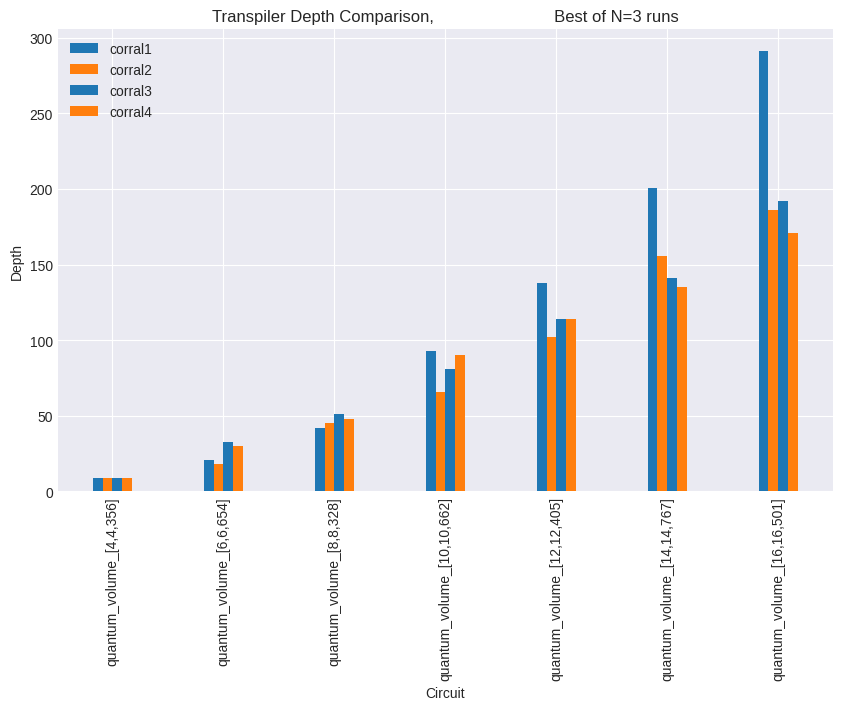

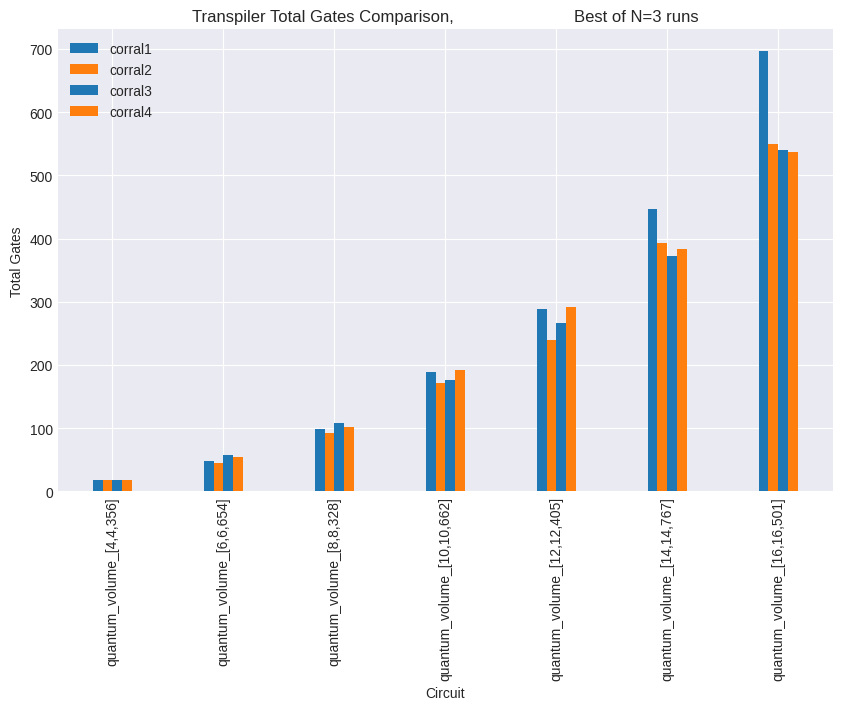

In [34]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    transpilers=[corral(corral_N_64_1_1, name='corral1'), 
     corral(corral_N_64_1_2, name='corral2'),
     corral(corral_N_64_1_3, name='corral3'),
     corral(corral_N_64_1_4, name='corral4')
     ],
    submodules=[qv_bench],
    metrics=[depth_metric, total_metric],
    logger = transpile_benchy_logger,
)
benchmark.run()
benchmark.plot(save=True)